In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Bidirectional,TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
def dataProcessing(dayNum, dataset):
    """
    A method for users to make multivariate time series for LSTM
    @param: dayNum, the number of days you want to use as the training set.
    @param: dataset, the period you want to predict, s.t. study_weekend, study_weekday, 
                                                          holiday_weekend, holiday_weekday
                     Dataset should be time series.
                     Dataset features(order important): PassengerFlow, TMax, TMin, Rain
    @return: X_train, y_train, X_test, y_test.  Training set 70%, Testing set 30% 
    """
    time_step =  dayNum * 15 * 4
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    a = np.zeros([scaled.shape[0]-time_step + 1, time_step ,4])
    for i in range(scaled.shape[0]-time_step+1):
        for j in range(time_step):
            a[i][j] = scaled[i + j]
    y = np.zeros(scaled.shape[0])
    for i in range(scaled.shape[0]):
        y[i] = scaled[i][0]
    size = round(a.shape[0]*0.7)
    
    #split train and test sets
    X_train = a[:size]
    X_test = a[size:-1]
    y_train = y[time_step:size+time_step]
    y_test = y[size+time_step:]
    
    return X_train, y_train, X_test, y_test

In [3]:
def myLSTM(X_train, y_train, layerNum, neuralNum, batchSize, epochs):
    """
    A well-designed method for users to create a LSTM model espicially for 
    Route 66 UQ Lake Station Passenger Flow Prediction.
    
    @param: X_train, training features
    @param: y_train, training labels
    @param: layerNum, the number of LSTM layers. Recommended between 1 and 3.
    @param: neuralNum, the number of neurals for every LSTM layer. Recommended between 0 and 500.
    @param: batchSize, the number of batchSize
    @param: epochs, the number of epochs
    @return: model, An LSTM model specified based on your input
    """
    # design network
    model = Sequential()
    model.add(LSTM(neuralNum, activation='relu',return_sequences=True,
                   input_shape=([X_train.shape[1], X_train.shape[2]])))
    for i in range(layerNum-1):
        model.add(LSTM(neuralNum, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchSize, validation_data=(X_test, y_test), 
                        callbacks=[earlystop_callback],verbose=2, shuffle=False)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    return model

In [18]:
def evaluateMyLSTM(model, X_test, y_test, dataset):
    """
    A method for users to evaluate their LSTM model by myLSTM().
    Showing a plot of prediction by model and real values for visualization.
    
    @param model, the model returned by myLSTM().
    @param X_test, testing features.
    @param y_test, testing labels.
    @param dataset, the dataset to tell scaler how to restore data
    @return rmse, the real Root-mean-square deviation value of data which has been restored.
    """
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    
    # make a prediction
    yhat = model.predict(X_test)
    inv_yhat = np.concatenate((yhat, np.zeros([y_test.shape[0], 3])), axis=1)
    y_true = np.concatenate((y_test.reshape([y_test.shape[0],1]), np.zeros([y_test.shape[0], 3])), axis=1)
    y_true = scaler.inverse_transform(y_true)[:,0]
    y_pre =  scaler.inverse_transform(inv_yhat)[:,0]
    
    #plot
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(111)
    ax.plot(y_true, label='true')
    ax.plot(y_pre, label='pred')
    ax.legend()
    
    rmse = math.sqrt(mean_squared_error(y_true, y_pre))
    print('Test RMSE: %.3f' % rmse)
    
    return rmse

In [29]:
holiday_weekend = pd.read_csv("holiday_weekend.csv")

In [30]:
holiday_weekend.head()

,Unnamed: 0,Date,Hour,Period,Passengers,TMax,TMin,Rain
0,0,2018-07-01,6,45,1.0,22.4,15.1,0.0
1,1,2018-07-01,7,15,1.0,22.4,15.1,0.0
2,2,2018-07-01,7,30,2.0,22.4,15.1,0.0
3,3,2018-07-01,7,45,3.0,22.4,15.1,0.0
4,4,2018-07-01,8,15,5.0,22.4,15.1,0.0


In [31]:
holiday_weekend = holiday_weekend.iloc[:,4:]

In [32]:
holiday_weekend.head()

,Passengers,TMax,TMin,Rain
0,1.0,22.4,15.1,0.0
1,1.0,22.4,15.1,0.0
2,2.0,22.4,15.1,0.0
3,3.0,22.4,15.1,0.0
4,5.0,22.4,15.1,0.0


In [33]:
X_train, y_train, X_test, y_test = dataProcessing(dayNum=1, dataset=holiday_weekend)

In [34]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (904, 60, 4)
y_train shape: (904,)
X_test shape: (386, 60, 4)
y_test shape: (386,)


Train on 904 samples, validate on 386 samples
Epoch 1/5
 - 6s - loss: 0.0168 - val_loss: 0.0167
Epoch 2/5
 - 6s - loss: 0.0120 - val_loss: 0.0154
Epoch 3/5
 - 6s - loss: 0.0107 - val_loss: 0.0155
Epoch 4/5
 - 6s - loss: 0.0114 - val_loss: 0.0159
Epoch 5/5
 - 6s - loss: 0.0108 - val_loss: 0.0148


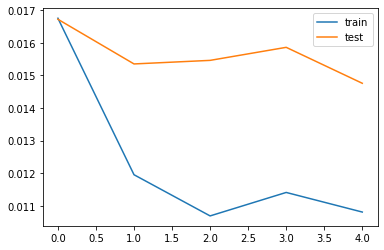

In [26]:
model = myLSTM(X_train, y_train, layerNum=2, neuralNum=256, batchSize=16, epochs=5)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 256)           267264    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 792,833
Trainable params: 792,833
Non-trainable params: 0
_________________________________________________________________


Test RMSE: 8.747


8.746762733599587

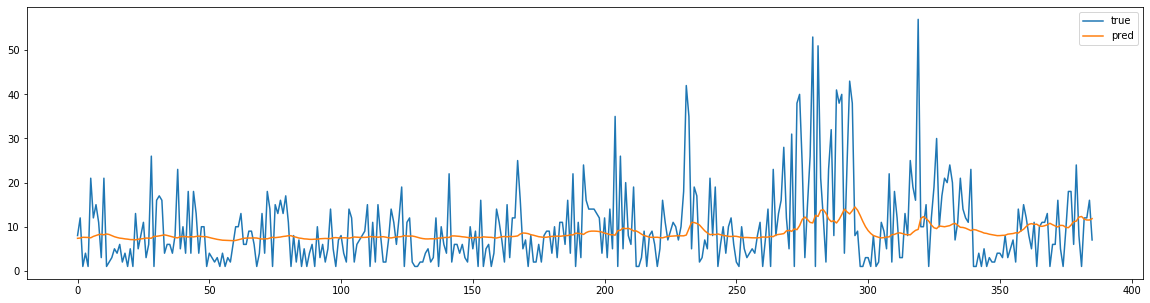

In [36]:
evaluateMyLSTM(model,X_test, y_test, holiday_weekend)